Created on Wednesday 13 January 2021

Group 5 - Classification

@authors : F.B

In [ ]:
!python3 -m spacy download fr_core_news_md

     |████████████████████████████████| 88.6MB 1.3MB/s 
  Created wheel for fr-core-news-md: filename=fr_core_news_md-2.2.5-cp36-none-any.whl size=90338490 sha256=7c5b20f4865c43fd8b3c02971c935ddbe6eae4d8a768bef583d18b312fbe21d9
  Stored in directory: /tmp/pip-ephem-wheel-cache-r2jmnu03/wheels/c6/18/b6/f628642acc7872a53cf81269dd1c394d96da69564ccfac5425
Successfully built fr-core-news-md
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_md')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/My Drive/G5 Inter-Promo 2021/Données/Input")

Mounted at /content/drive


In [ ]:
import sys
sys.setrecursionlimit(10000)

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.decomposition import PCA

from nltk.stem import  WordNetLemmatizer
lemmer=WordNetLemmatizer()
import nltk
nltk.download('wordnet')
from textblob import TextBlob
import spacy
import fr_core_news_md
nlp = fr_core_news_md.load()

from sklearn import cluster
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn import metrics
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
bow :pd.DataFrame= pd.read_json("g3_BOW_v1.json")
bow.head()

,art_id,art_content_clean_without_lem,abonnement,abord,aborde,aborder,abordes,aboutir,abri,absence,absolue,absolument,academie,academique,academiques,acceder,accelerateur,acceleration,accelere,acceleree,accelerer,accent,accentuer,acceptable,accepte,accepter,acces,accessibilite,accessible,accessibles,accident,accidents,accompagnant,accompagne,accompagnee,accompagnement,accompagnent,accompagner,accompagnes,accompli,...,volets,volontaire,volontaires,volontariste,volonte,volume,volumes,vont,vote,votee,voter,votes,voudrais,voulais,voulez,vouloir,voulons,voulu,voyage,voyez,voyons,vrai,vraie,vraies,vraiment,vrais,vu,vue,vues,vulnerables,web,week,www,xxie,yeux,yves,zero,zone,zones,œuvre
1,1,fncdg andcdg publie septembre eme edition pano...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,malgre levee mesures confinement mai plupart m...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
25,25,quels etaient objectifs poursuivis gouvernemen...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
27,27,journee thematique lieu durant salon preventic...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
28,28,ere journee thematique region theme vers nouve...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# this function allows you to lemmatize English words

def lemmatization(word : str) -> str:
  """
  parameters
    word : word to lemmatize
  Output
    word : lemmatized word
  """
  for pos in ['a', 's', 'r', 'n', 'v']:
    word=lemmer.lemmatize(word, pos)
  return word

In [ ]:
# This function allows you to clean up keywords

def clean_keyword(link_keyword : str, bow : pd.DataFrame = bow) -> list:
  """
  Parameters :
      link_keyword : link of keyword
      bow : bow dataframe 
    Output : 
      list_key_word : list of cleaned keywords 
  """

  df_lexique: pd.DataFrame = pd.read_csv(link_keyword, sep="  ", header=None)
  df_lexique.columns: list = ['key_word']
  list_key_word = df_lexique.key_word.values.tolist()
  list_key_word_need : list = []

  columns_bow = bow.columns
  stop_word =[ 'le', 'par', 'les', 'du', 'la', 'de']

  #
  for key in list_key_word :
    for k in key.split():
      if k in columns_bow and k not in stop_word:
        list_key_word_need.append(k)

    #
    blob = TextBlob(key)
    try :
      if blob.detect_language()=='fr':
        k_npl=nlp(key)
        for j in k_npl:
          jj = j.lemma_
          if jj in columns_bow and k not in stop_word:
            list_key_word_need.append(jj)
      elif blob.detect_language()=='en' :
        for k in key.split():
          kk = lemmatization(k)
          if kk in columns_bow and k not in stop_word:
            list_key_word_need.append(kk)
    except :
      pass 



  list_key_word_need = pd.unique(list_key_word_need).tolist()
  return list_key_word_need

link_keyword = "/content/drive/MyDrive/G5 Inter-Promo 2021/Ressources/Lexique_Innovation.txt"
list_key_word_need = clean_keyword(link_keyword)
list_key_word_need [ : 5]

['innovation', 'migration', 'automatique', 'ligne', 'produits']

In [ ]:
data = bow[list_key_word_need]

# Classification

In [ ]:
data.describe()

,innovation,migration,automatique,ligne,produits,produit,iot,recherche,machine,learning,ia,intelligence,artificielle,traitement,langage,analyse,image,data,information,augmenter,virtuelle,virtuel,mixte,sociale,social,si,algorithmes,description,base,design,reconnaissance,objet,big,digital,cloud,connaissances,connaissance,interface,smart,city,ville,futur,industrie,optimisation,moteur,experience,web,durable,interfaces,intelligentes,intelligent,digitalisation,saas,fusion,aide,code,ordinateur,autonome,it,conjoncture,enjeux,enjeu,prospective,nouvelle,nouveau
count,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.00000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000,7533.000000
mean,1.029869,0.016859,0.028939,0.280234,0.289393,0.133546,0.017788,1.168326,0.032789,0.029072,0.052170,0.173636,0.081508,0.166202,0.020709,0.218240,0.096774,0.104606,0.436878,0.085092,0.016726,0.013806,0.025753,0.418691,0.308642,1.204301,0.018054,0.011018,0.195274,0.060135,0.081243,0.200982,0.044604,0.083765,0.232577,0.072216,0.151334,0.021107,0.076198,0.048055,0.429975,0.092924,0.379796,0.041020,0.046197,0.243728,0.084030,0.224612,0.012346,0.015664,0.024824,0.060268,0.044073,0.045931,0.24479,0.098367,0.030665,0.022302,0.026815,0.023497,0.280897,0.206292,0.027745,0.548387,0.392672
std,3.352821,0.218276,0.211113,0.980250,1.114711,0.553995,0.211089,4.900803,0.356061,0.373483,0.792833,1.104527,0.894008,0.767945,0.198497,0.749864,0.429039,0.717134,1.225679,0.370596,0.227519,0.201746,0.237542,1.763178,1.156466,2.777809,0.195388,0.117555,0.600247,1.041476,0.446602,0.628762,0.451441,0.521465,1.480737,0.454329,0.653180,0.171543,0.632609,0.474888,1.853371,0.425700,2.200710,0.256701,0.272165,0.793337,0.494232,1.032398,0.132309,0.176317,0.225898,0.419683,0.384817,0.376928,0.95272,0.525266,0.222212,0.198993,0.366295,0.243023,0.914829,0.650934,0.213461,1.201522,0.928718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0

In [ ]:
# Centre and reduce
data_scale = scaler.fit_transform(data)

In [ ]:
# generate the link matrix
Z = linkage(data_scale, method='ward', metric='euclidean')

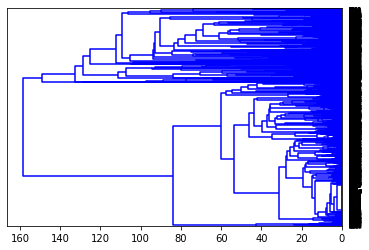

In [ ]:
# dendrogram display
dendrogram(Z, orientation='left', color_threshold=0)
plt.show()

In [ ]:
kmeans = cluster.KMeans(n_clusters=2)
kmeans.fit(data)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
#use of "silhouette" metrics


#Vary the number of clusters from 2 to 10
res = np.arange(9,dtype="double")
for k in np.arange(9):
  km = cluster.KMeans(n_clusters=k+2)
  km.fit(data)
  res[k] = metrics.silhouette_score(data,km.labels_)
res[:3]

array([0.74618757, 0.66001614, 0.5486887 ])

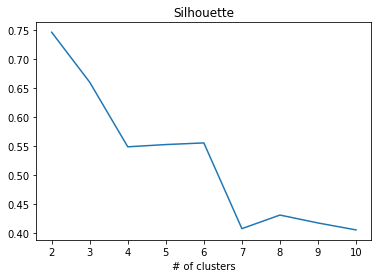

In [ ]:
#graphic

plt.title("Silhouette")
plt.xlabel("# of clusters")
plt.plot(np.arange(2,11,1),res)
plt.show()

In [ ]:
# The partition in k = 2 groups seems to be the better in the sense of the metric "silhouette". 

# Labelling

In [ ]:
data ['label_innovation'] = kmeans.labels_

In [ ]:
# Detecting the class of non-innovative documents 
count_keyword = np.sum(data[list_key_word_need].T).tolist()
data ['count_keyword'] = count_keyword



# the class of non-innovative items
dff = data[data['count_keyword']==0]
classe = pd.unique(dff.label_innovation.values).tolist()
classe

[0]

In [ ]:
# Assign 1 to the class of innovative items and 0 otherwise
if len(classe)==1 and classe[0]!=0 :
  data['label_innovation'].replace(1,-1, inplace=True)
  data['label_innovation'].replace(0,1, inplace=True)
  data['label_innovation'].replace(-1,0, inplace=True)

In [ ]:
# 
data.drop('count_keyword', axis=1, inplace=True)

In [ ]:
# this function allows you to train a model either by cross validation 
# and display its accuracy and f1_score or by simple training 
# and display its accuracy and f1_score and also its confusion matrix if you wish.

def training(model, if_plot : bool = False, if_val_cross : bool = False) :
  """
  Parameters :
    model : model
    if_plot : if you want to display your confusion matrix
    if_val_cross : if you want to train by cross-validation
    Output :
  """
  if if_val_cross :
    print("accuracy ...")
    print(cross_val_score(model, X, y, cv=5))

    print("f1_score ...")
    print(cross_val_score(model, X, y, cv=5, scoring='f1'))

  else :

    X_train, X_val, Y_train, Y_val = train_test_split (X, y, test_size = 0.30, random_state = 40) 
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_val)

    print("accuracy ...")
    print(model.score(X_val, Y_val))
    print("f1_score ...")
    print(f1_score(Y_val, y_pred))

    if if_plot:
      plot_confusion_matrix(model, X_val, Y_val, cmap='Blues', normalize=None,
                      display_labels=['No innovation', 'Innovation']);

logit
accuracy ...
0.9991150442477876
f1_score ...
0.9846153846153847
----------------------------------------------------
rf
accuracy ...
0.9951327433628319
f1_score ...
0.907563025210084
----------------------------------------------------
lgbm
accuracy ...
0.9969026548672566
f1_score ...
0.9457364341085271
----------------------------------------------------


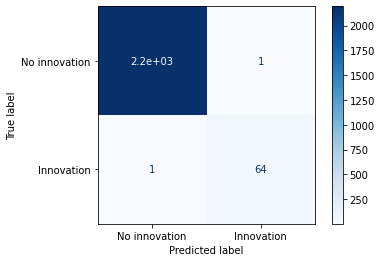

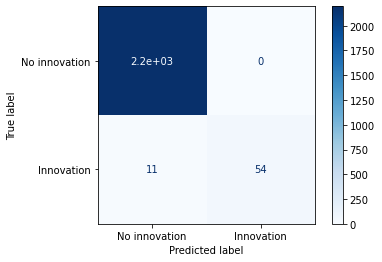

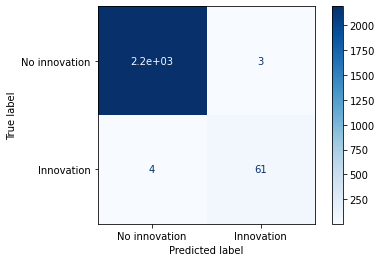

In [ ]:
X = data.drop('label_innovation', axis=1).values
y = data.label_innovation.values

models = {
    'logit' : LogisticRegression(),
    'rf' : RandomForestClassifier(),
    'lgbm': LGBMClassifier()
}


for model in models.keys():
  print(model)
  training(models[model], True)
  print('----------------------------------------------------')

In [ ]:
for model in models.keys():
  print(model)
  training(models[model], False, True)
  print('----------------------------------------------------')

logit
accuracy ...
[0.99071002 1.         1.         0.99933599 0.99734396]
f1_score ...
[0.87037037 1.         1.         0.98924731 0.95652174]
----------------------------------------------------
rf
accuracy ...
[0.99137359 0.99668215 0.99601858 0.99535193 0.9940239 ]
f1_score ...
[0.86538462 0.93181818 0.96774194 0.91954023 0.91954023]
----------------------------------------------------
lgbm
accuracy ...
[0.9800929  0.99867286 0.99867286 0.99667995 0.99867198]
f1_score ...
[0.75806452 0.97826087 0.9787234  0.94382022 0.97826087]
----------------------------------------------------


# Output

In [ ]:
print('The number of relevant documents :',len(y[y==1]))

The number of relevant documents : 236


In [ ]:
label = pd.DataFrame(bow.art_id.tolist() , columns=['art_id'])
label ['label_innovation'] = y
label.head()

,art_id,label_innovation
0,1,0
1,2,0
2,25,0
3,27,0
4,28,0


In [ ]:
label.to_csv('../Output/label_innovation_unsupervised_CAH.csv', index=False)